In [1]:
!pip install qiskit
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=99cb4d95f1f7161e9e294700e72b40c74fcb24999245d5566d1bdc2a5a9f8433
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


#Teleportation

In [3]:
!pip install qiskit_aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 36.5 MB/s eta 0:00:00


In [4]:
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

<b>Note:</b>
In quantum computing, you often measure multiple qubits at once, resulting in a joint probability distribution over the possible outcomes. However, sometimes you are only interested in the distribution of a subset of the qubits. This is where marginal_distribution comes in handy.

Example:
Suppose you have a probability distribution for a 3-qubit system, but you are only interested in the marginal distribution of the first two qubits. The marginal_distribution function allows you to extract this information.

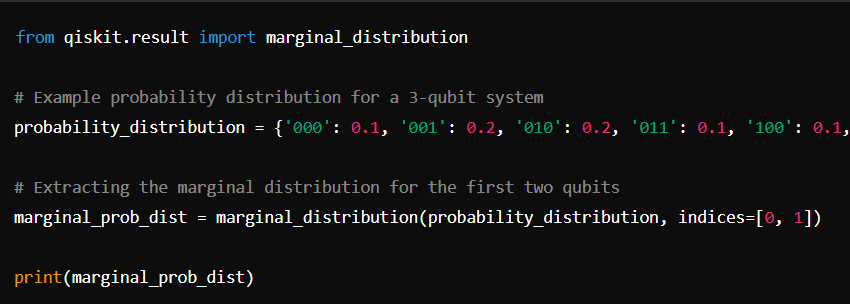

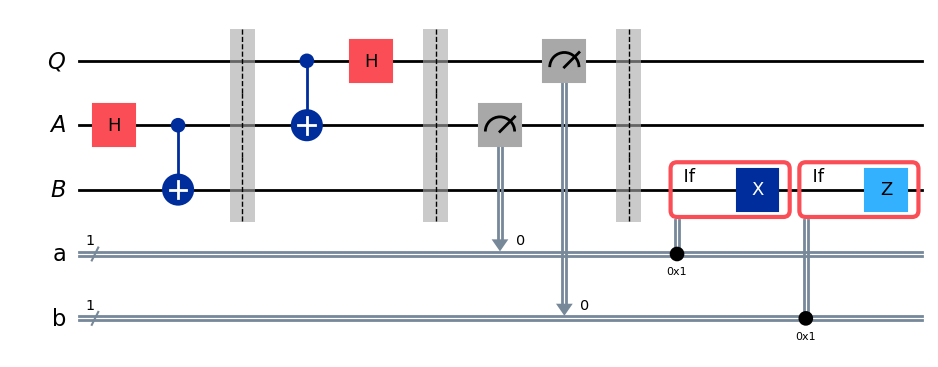

In [6]:
qubit = QuantumRegister(1,'Q')
ebit0 = QuantumRegister(1,'A')
ebit1 = QuantumRegister(1,'B')
a = ClassicalRegister(1,'a')
b = ClassicalRegister(1,'b')

protocol = QuantumCircuit(qubit , ebit0 , ebit1, a, b)

# preparing ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0,ebit1)
protocol.barrier()

# alice's operations
protocol.cx(qubit,ebit0)
protocol.h(qubit)
protocol.barrier()

# alice measure and sends classical bits to bob
protocol.measure(ebit0,a)
protocol.measure(qubit,b)
protocol.barrier()

# bob uses the classical bits to conditionally apply gates
with protocol.if_test((a,1)):
  protocol.x(ebit1)
with protocol.if_test((b,1)):
  protocol.z(ebit1)
display(protocol.draw('mpl'))



To test that the protocol works correctly, we'll apply a randomly generated single-qubit gate to the initialized
∣
0
⟩
∣0⟩ state of
𝑄
Q to obtain a random quantum state vector to be teleported. By applying the inverse (i.e., conjugate transpose) of that gate to
𝐵
B after the protocol is run, we can verify that the state was teleported by measuring to see that it has returned to the
∣
0
⟩
∣0⟩ state.

In [7]:
random_gate = UGate(
    theta = random.random()*2*pi,
    phi = random.random()*2*pi,
    lam = random.random()*2*pi,
)
display(random_gate.to_matrix())

array([[-0.15494224+0.j        ,  0.98501174-0.07579427j],
       [ 0.86563964-0.47608919j,  0.12963495-0.08486387j]])

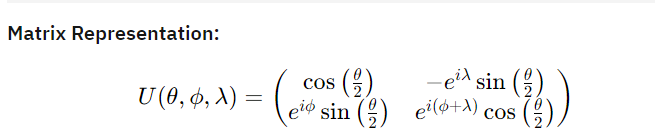

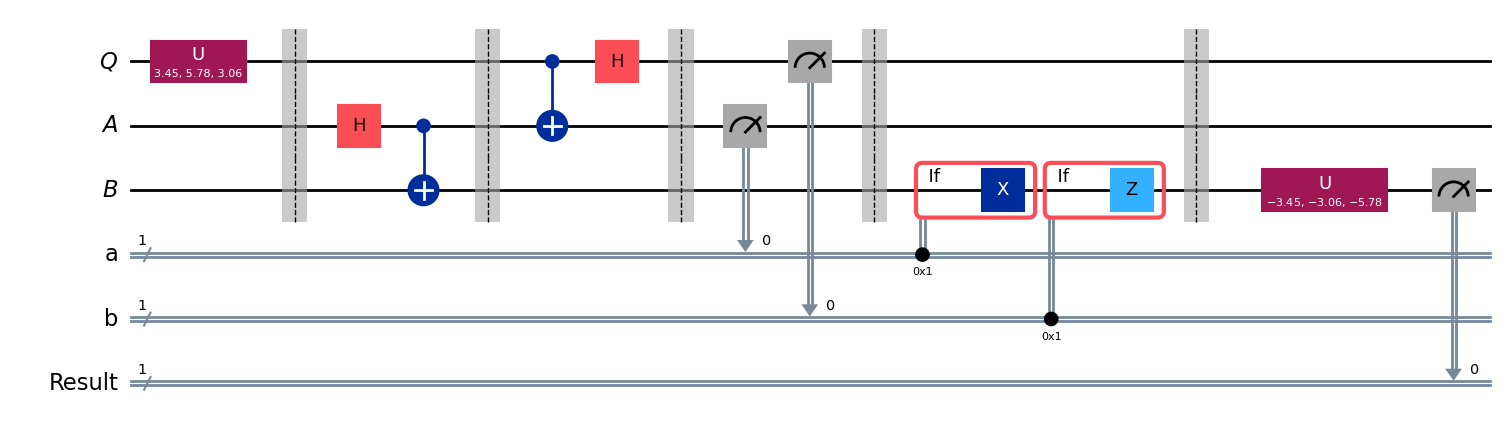

In [8]:
# create a new ckt with same bits and qubit
# teleportation protocol

test = QuantumCircuit(qubit, ebit0 , ebit1, a, b)

#start with randomly selected gate on Q
test.append(random_gate , qubit)
test.barrier()

#append entire teleportation protocol from above
test = test.compose(protocol)
test.barrier()

# apply inverse of the random unitary to B and measure
test.append(random_gate.inverse(),ebit1)
result = ClassicalRegister(1,'Result')
test.add_register(result)
test.measure(ebit1,result)
display(test.draw('mpl'))

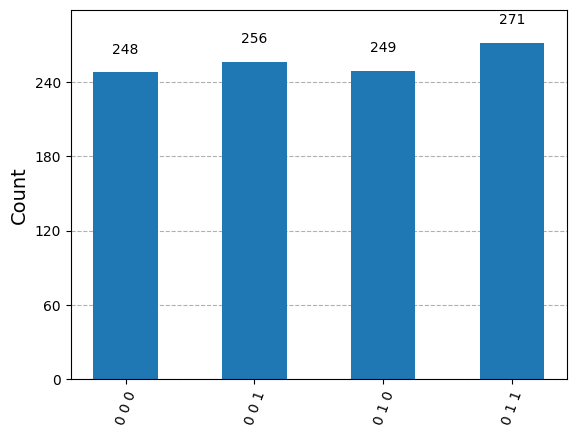

In [9]:
result = AerSimulator().run(test).result()
stats = result.get_counts()
display(plot_histogram(stats))

We can also filter the statistics to focus just on the test result qubit if we wish, like this:

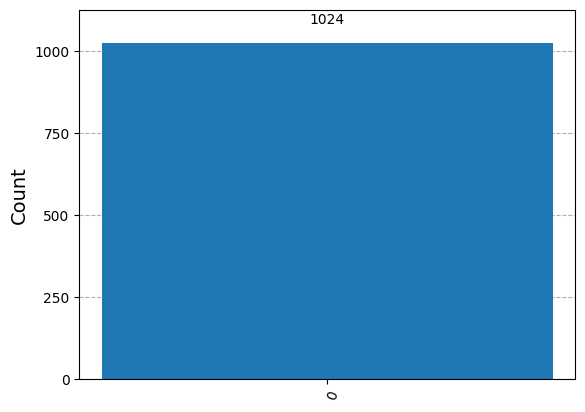

In [11]:
filtered_stats = marginal_distribution(stats,[2])
display(plot_histogram(filtered_stats))

#Superdense Coding

In [12]:
from qiskit_aer.primitives import Sampler

The Sampler from qiskit_aer.primitives is a powerful tool for simulating quantum circuits and sampling measurement outcomes efficiently on classical computers. It is especially useful for development, testing, and educational purposes in the field of quantum computing.







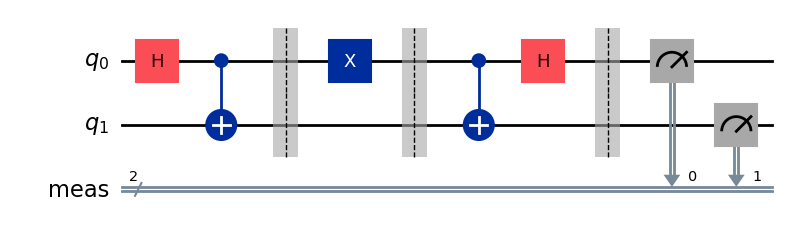

In [13]:
c = '1'
d = '0'

protocol = QuantumCircuit(2)
protocol.h(0)
protocol.cx(0,1)
protocol.barrier()

#alice's opr
if d == '1':
  protocol.z(0)
if c == '1':
  protocol.x(0)
protocol.barrier()

#bob's actions
protocol.cx(0,1)
protocol.h(0)
protocol.measure_all()

display(protocol.draw('mpl'))

Measured 10 with freq 1.0


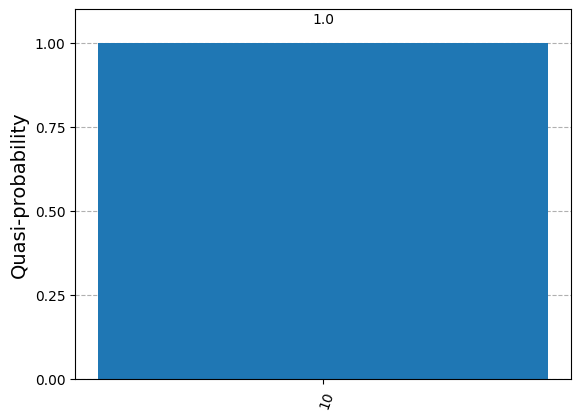

In [14]:
result = Sampler().run(protocol).result()
stats = result.quasi_dists[0].binary_probabilities()
for outcome,freq in stats.items():
  print(f'Measured {outcome} with freq {freq}')
display(plot_histogram(stats))

Just for fun, we can use an additional qubit as a random bit generator to randomly choose
𝑐
c and
𝑑
,
d, then run the superdense coding protocol to see that these bits are transmitted correctly.

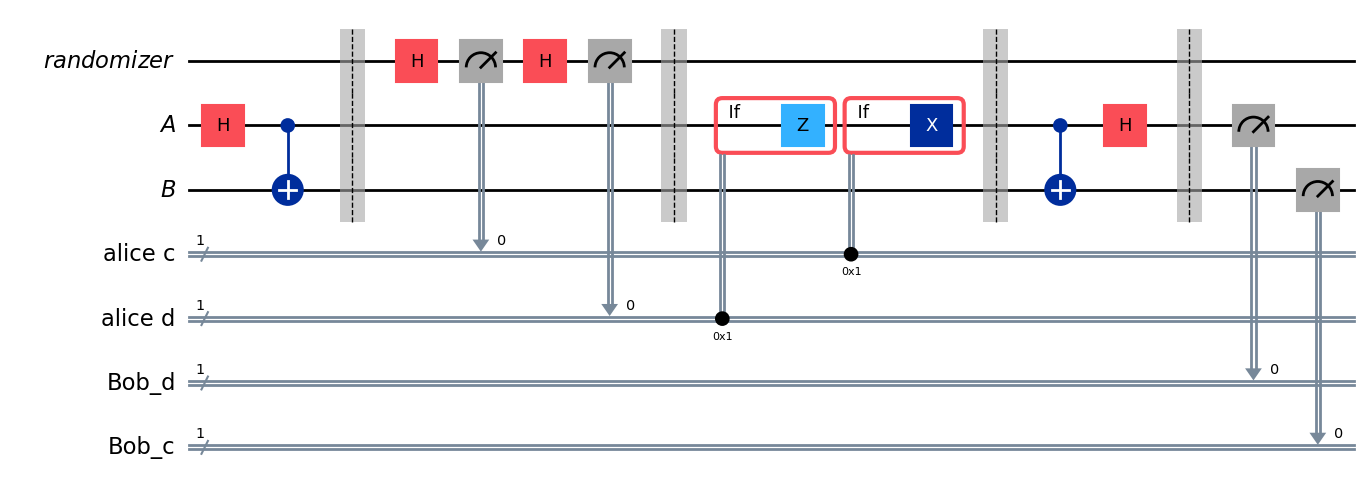

In [15]:
rbg = QuantumRegister(1,'randomizer')
ebit0 = QuantumRegister(1,'A')
ebit1 = QuantumRegister(1,'B')

alice_c = ClassicalRegister(1,'alice c')
alice_d = ClassicalRegister(1,'alice d')

test = QuantumCircuit(rbg, ebit0 , ebit1, alice_c, alice_d)

# initialize the ebit
test.h(ebit0)
test.cx(ebit0,ebit1)
test.barrier()

#use the randomizer qubit twice to generate alice's bits c and d
test.h(rbg)
test.measure(rbg,alice_c)
test.h(rbg)
test.measure(rbg,alice_d)
test.barrier()

# alice actions depends onn her qubits
with test.if_test((alice_d,1),label='Z'):
  test.z(ebit0)
with test.if_test((alice_c,1), label='X'):
  test.x(ebit0)
test.barrier()

#bob's actions
test.cx(ebit0,ebit1)
test.h(ebit0)
test.barrier()

Bob_c = ClassicalRegister(1,'Bob_c')
Bob_d = ClassicalRegister(1,'Bob_d')
test.add_register(Bob_d)
test.add_register(Bob_c)
test.measure(ebit0,Bob_d)
test.measure(ebit1,Bob_c)
display(test.draw('mpl'))

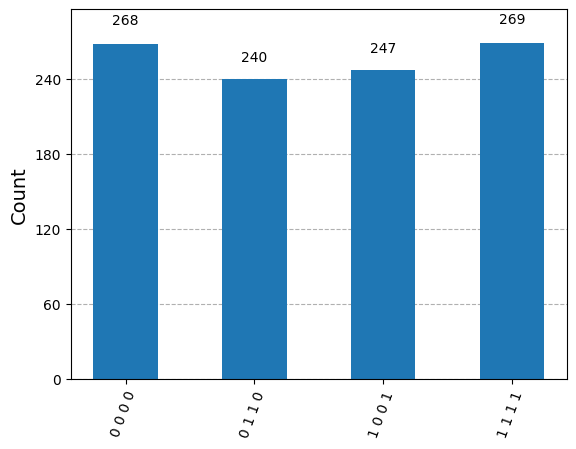

In [16]:
result = AerSimulator().run(test).result()
stats = result.get_counts()
display(plot_histogram(stats))

#CHSH Game

In [17]:
from numpy.random import randint


In [18]:
def chsh_game(stategy):
  x,y=randint(0,2),randint(0,2) # referee chooses x,y randomly
  a,b=stategy(x,y) # use stategy to choose a,b
  if (a !=b) == (x & y):
    return 1 # win
  return 0 # lose

In [24]:
def chsh_circuit(x,y):
  qc = QuantumCircuit(2,2)
  qc.h(0)
  qc.cx(0,1)
  qc.barrier()

  #alice
  if x==0:
    qc.ry(0,0)
  else:
    qc.ry(-pi/2,0)
  qc.measure(0,0)

  # bob
  if y ==0:
    qc.ry(-pi/4,1)
  else:
    qc.ry(pi/4,1)
  qc.measure(1,1)

  return qc

(x,y) = (0,0)


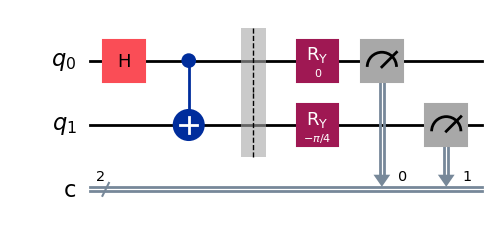

(x,y) = (0,1)


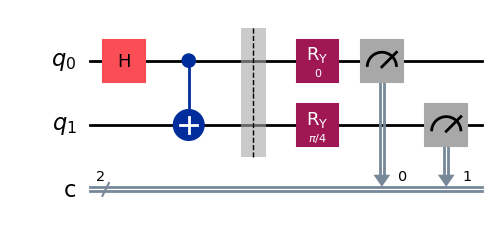

(x,y) = (1,0)


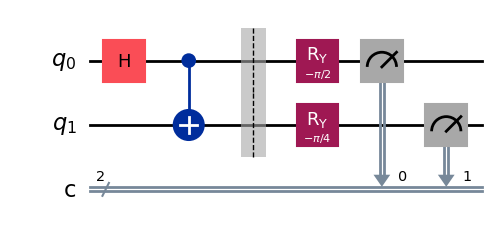

(x,y) = (1,1)


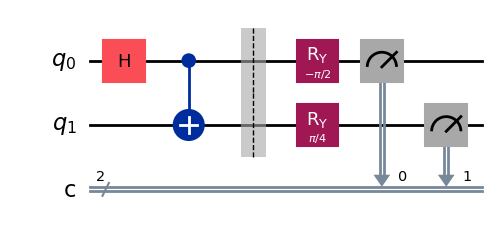

In [25]:
print("(x,y) = (0,0)")
display(chsh_circuit(0,0).draw('mpl'))

print("(x,y) = (0,1)")
display(chsh_circuit(0,1).draw('mpl'))

print("(x,y) = (1,0)")
display(chsh_circuit(1,0).draw('mpl'))

print("(x,y) = (1,1)")
display(chsh_circuit(1,1).draw('mpl'))

In [26]:
sampler = Sampler()

def quantum_strategy(x,y):
  result = sampler.run(chsh_circuit(x,y),shots=1).result()
  stats = result.quasi_dists[0].binary_probabilities()
  bits = list(stats.keys())[0]
  a,b = bits[0],bits[1]
  return a,b

In [27]:
# we'll play 1000 times and compute fraction of them that strategy wins

num_games = 1000
total_score = 0

for _ in range(num_games):
  total_score += chsh_game(quantum_strategy)
print('fraction of games won:',total_score / num_games)

fraction of games won: 0.877


In [28]:
def classical_strategy(x,y):

  #alice's answer
  if x==0:
    a=0
  elif x==1:
    a = 1

  # bob's answer
  if y==0:
    b=1
  elif y==1:
    b=0
  return a,b

In [29]:
num_games = 1000
total_score = 0
for _ in range(num_games):
  total_score +=chsh_game(classical_strategy)
print('fraction of games won:',total_score/num_games)

fraction of games won: 0.757
